# Here is some code for segmenting images
- Use DBScan to make clusters from a black and white threshold of the image
- Then use those clusters to take just small parts of the image

In [87]:
import numpy as np
from PIL import Image
from sklearn.cluster import DBSCAN
import math
from statistics import median

color_array = [
    '#9e0142', '#fee08b', '#66c2a5',
    '#d53e4f', '#bf812d', '#3288bd',
    '#f46d43', '#e6f598', '#5e4fa2',
    '#fdae61', '#abdda4', '#66b2f9',
    '#9e0142', '#fee08b', '#66c2a5',
    '#d53e4f', '#bf812d', '#3288bd',
    '#f46d43', '#e6f598', '#5e4fa2',
    '#fdae61', '#abdda4', '#66b2f9',
    '#9e0142', '#fee08b', '#66c2a5',
    '#d53e4f', '#bf812d', '#3288bd',
    '#f46d43', '#e6f598', '#5e4fa2',
    '#fdae61', '#abdda4', '#66b2f9',
    '#9e0142', '#fee08b', '#66c2a5',
    '#d53e4f', '#bf812d', '#3288bd',
    '#f46d43', '#e6f598', '#5e4fa2',
    '#fdae61', '#abdda4', '#66b2f9'
]

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(color_array)
%matplotlib inline

In [139]:
# here are some options from https://www.codementor.io/isaib.cicourel/image-manipulation-in-python-du1089j1u
def open_image(path):
    newImg = Image.open(path)
    return newImg

def save_image(image, path):
    image.save(path, 'png')
    
def create_image(i, j):
    image = Image.new("RGB", (i, j), "white")
    return image

def get_pixel(image, i, j):
    
    # is in bound?
    width, height = image.size
    if i > width or j > height:
        return None
    
    # if ok, return pixel
    pixel = image.getpixel((i, j))
    return pixel

def convert_grayscale(image):
    # get the size
    width, height = image.size
    
    # create the new image and the pixel iter
    new = create_image(width, height)
    pixels = new.load()
    
    for i in range(width):
        for j in range(height):
            # get the pixel
            pixel = get_pixel(image, i, j)
            #get the RGB values
            red = pixel[0]
            green = pixel[1]
            blue = pixel[2]
            
            # trasform to greyscale
            gray = (red * 0.299) + (green * 0.587) + (blue * 0.114)
#             gray = (red + green + blue) / 3
            
            # set the pixel
            pixels[i, j] = (int(gray), int(gray), int(gray))
    
    return new

def threshold_grascale_image(image, threshold):
    """Thresholds a grayscale image based on provided value"""
    
    # get the size
    width, height = image.size
    
    # create the new image and the pixel iter
    new = create_image(width, height)
    pixels = new.load()
    
    for i in range(width):
        for j in range(height):
            # get the pixel
            pixel = get_pixel(image, i, j)
            
            #get the pixel value. there are 3 of these, we only need 1
            gray = pixel[0]
            
            # keep if above the value, discard if below
            # black = 0, white is 255
            # if something is not infomative, I want it to be 0.
            # This is because of how I am going to quantify the image
            # later - drop 0's keep the best values
            if gray > threshold:
                gray = 0
            else:
                gray = 255

            # set the pixel
            pixels[i, j] = (int(gray), int(gray), int(gray))
    
    return new

def image_array(image):
    """
    Scans over a thresholded image, 
    gathers the points that have a value,
    Returns an np array of the points as coordinates
    """
    
    # get the size
    width, height = image.size
        
    x = []
    y = []
    for i in range(width):
        for j in range(height):
            # get the pixel
            pixel = get_pixel(image, i, j)
            
            #get the pixel value. there are 3 of these, we only need 1
            gray = int(pixel[0])
            
            ## save positions that have values
            if gray:
                x.append(i)
                y.append(-j)
    X = np.array(list(zip(x, y)))
    return X

def slice_image(image, points):
    """Grab a rectangular slice of an image based on a list of points"""

    # figure out all the maxes and mins
    xs = [math.sqrt(i[0]*i[0]) for i in points]
    ys = [math.sqrt(i[1]*i[1]) for i in points]
    xmin = int(min(xs))
    xmax = int(max(xs))
    ymin = int(min(ys))
    ymax = int(max(ys))
    width = xmax - xmin + 1
    height = ymax - ymin + 1
    
    # make a new image based on those dimensions
    new = create_image(width, height)
    pixels = new.load()
    
    # map the points of the old image onto the new one
    for point in points:
        x = math.sqrt(point[0] * point[0])
        y = math.sqrt(point[1] * point[1])
        i = x - xmin
        j = y - ymin
        pixel = get_pixel(image, x, y)
        pixels[i, j] = (pixel[0],pixel[1],pixel[2])
    
    return new

def plot_flies(fly_pics):
    """
    Input: Dictionary of cluster numbers and PIL images of those clusters
    Plots each image
    """
    
    rows = int(len(list(fly_pics.keys())) / 5) + 1
    
    fig, subfigs = plt.subplots(rows, 5, figsize=((3*5), (4*rows)))

    col = 0
    row = 0
    for img in fly_pics:
        
        stitle = str(img)
        subfigs[row, col].imshow(fly_pics[img])
        subfigs[row, col].set_title(stitle)
        
        if col == 4:
            col = 0
            row += 1
        else:
            col += 1

def trim_areas(blobs):
    areas = []
    new = {}
    for points in blobs:
        areas.append(len(blobs[points]))
    
    thresh = median(areas) / 5
    if thresh < 50:
        top_third = int(2 * (len(areas) / 3))
        thresh = median(sorted(areas)[top_third:]) / 5
    
    for points in blobs:
        if (len(blobs[points]) > thresh) and (points != -1):
            new[points] = blobs[points]
    return new

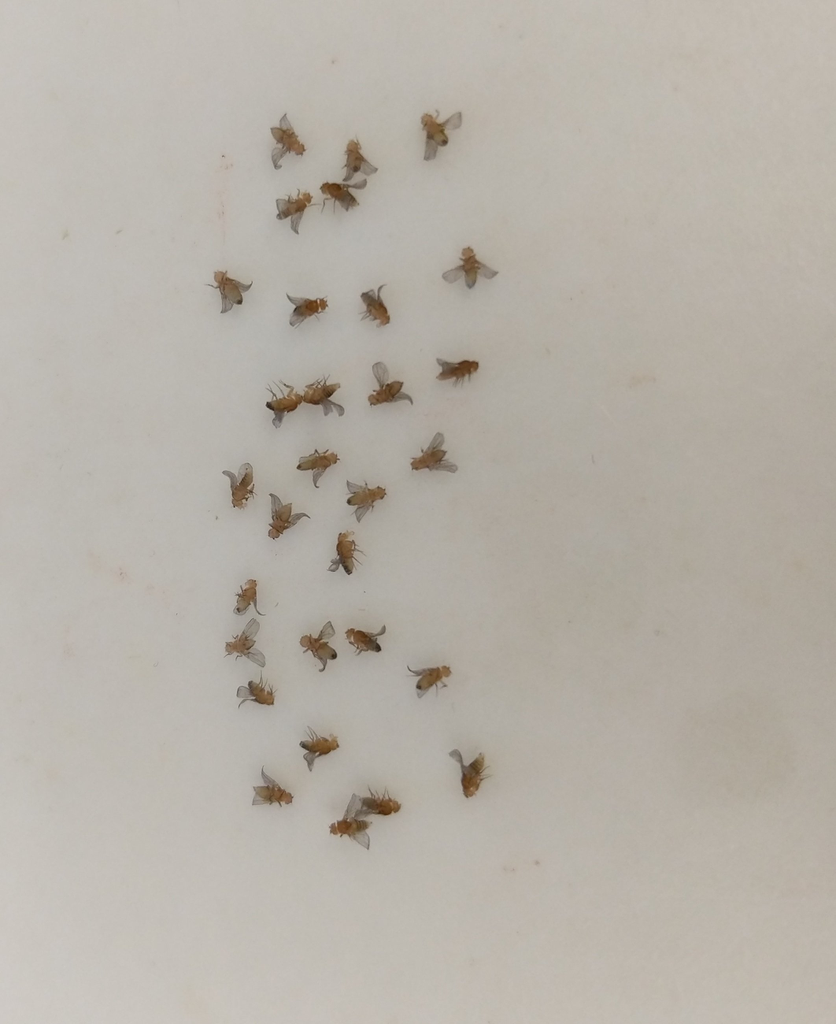

In [147]:
# p = 'IMG_clip_20181219_131627.jpg' # 39
p = 'IMG_clip_20181219_130926.jpg' # 30
# p = 'IMG_clip_20181219_131643.jpg' # 37
# p = 'IMG_clip_20181219_131242.jpg' # 74

img_path = 'test_images/' + p

first_img = open_image(img_path)
size = 1024, 1024
first_img.thumbnail(size, Image.ANTIALIAS)
first_img

Cluster number: 97


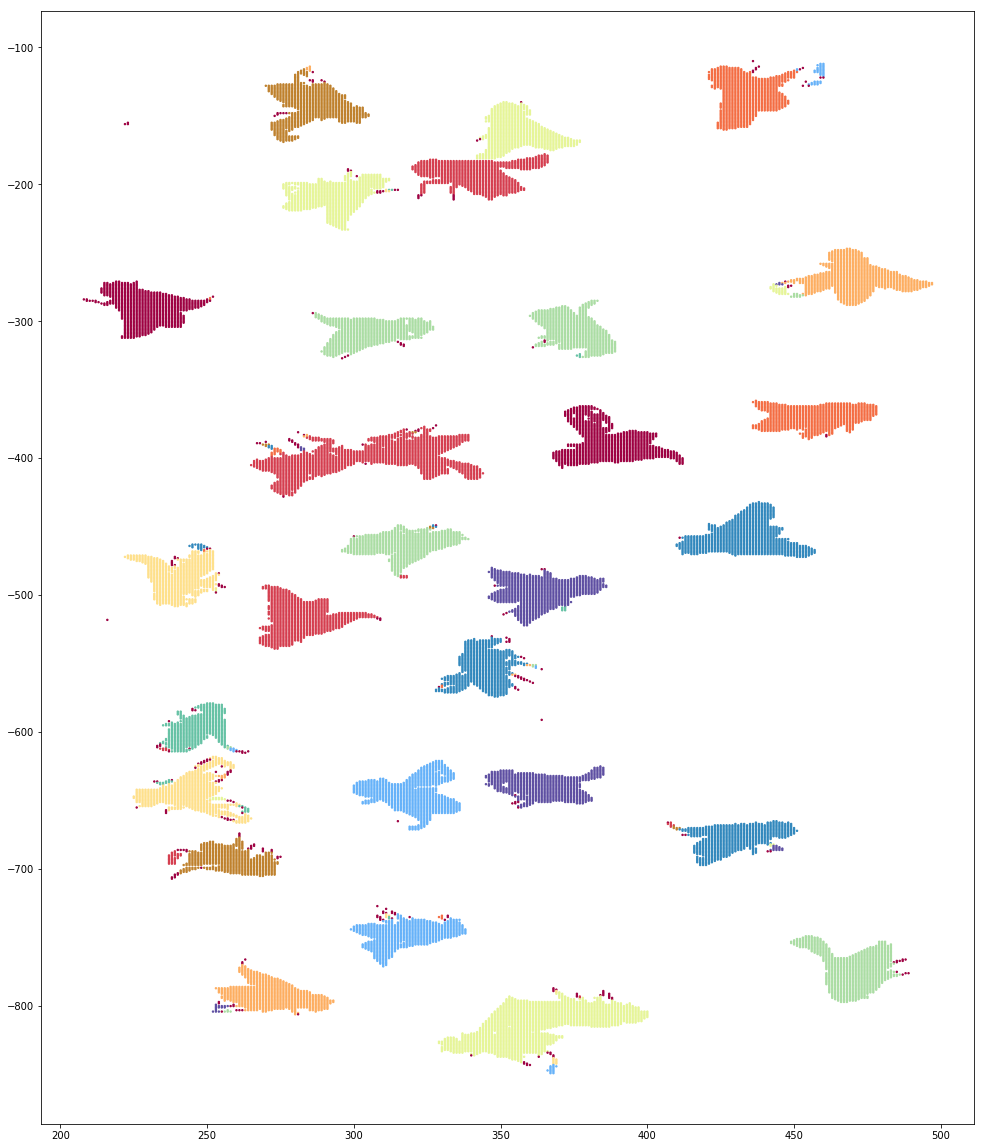

In [148]:
gray_img = convert_grayscale(first_img)
img = threshold_grascale_image(gray_img, 140)
X = image_array(img)

eps = 1
min_samples = 4

db_model = DBSCAN(eps=eps, min_samples=min_samples)
db_model.fit(X)
y_pred = db_model.fit_predict(X)
print("Cluster number: {}".format(len(set(y_pred))))


xs = list(X[:, 0])
ys = list(X[:, 1])

w,h = img.size
plt.rcParams['figure.figsize'] = (w/50, h/50)
plt.scatter(xs, ys, s=2, c=y_pred,  marker="o", cmap=cmap);
plt.show()

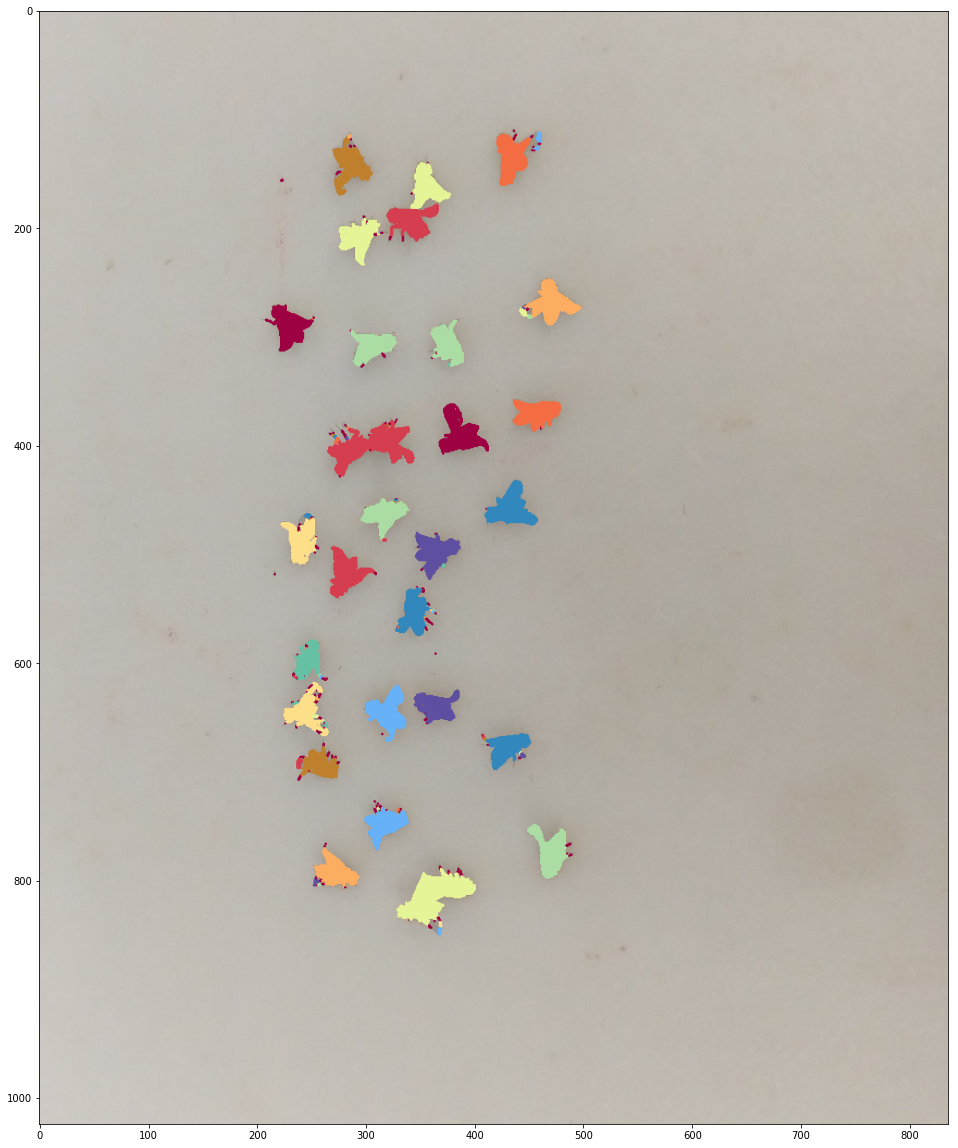

In [149]:
xs = [math.sqrt(i*i) for i in xs]
ys = [math.sqrt(i*i) for i in ys]

w,h = img.size
plt.rcParams['figure.figsize'] = (w/50, h/50)
implot = plt.imshow(first_img)
plt.scatter(xs, ys, s=2, c=y_pred,  marker="o", cmap=cmap);
plt.show()

In [150]:
## make images slices of all the flies
blobs = {}
for idx, pred in enumerate(y_pred):
    if pred not in blobs:
        blobs[pred] = []
    point = (X[idx][0], X[idx][1])
    blobs[pred].append(point)

blobs = trim_areas(blobs)
print(len(blobs))

blob_ims = {}
for blob in blobs:
    blob_ims[blob] = slice_image(first_img, blobs[blob])

28


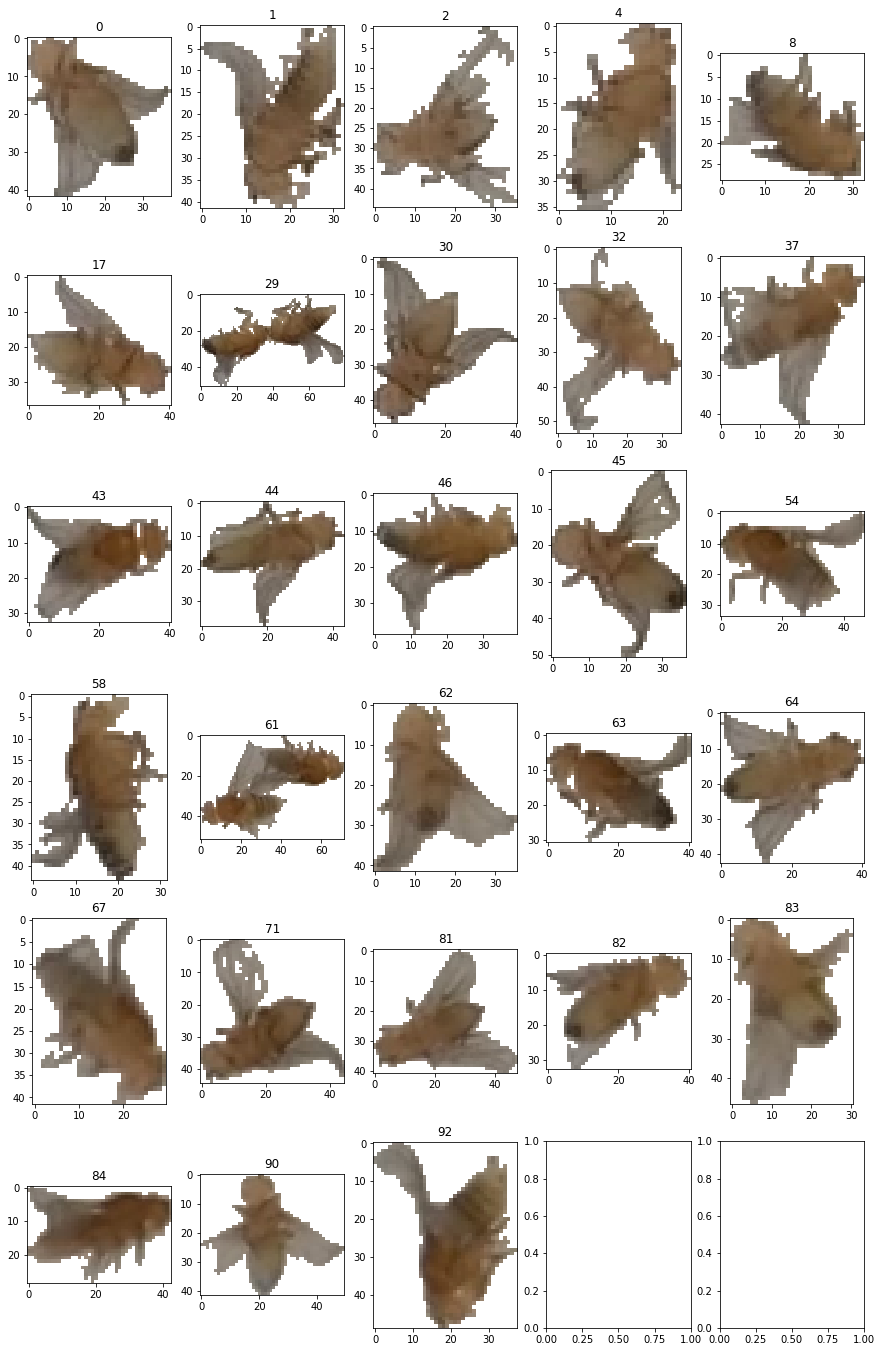

In [151]:
plot_flies(blob_ims)